# **Movie Script Analysis**

This work was underlined by studies done in the research paper "The emotional arcs of stories are dominated by six basic shapes" by Andrew J. Reagan, Lewis Mitchell, Dilan Kiley, Christopher M. Danforth, and Peter Sheridan Dodds,published on July 8, 2016.

## **Libraries Installation**

In [1]:
import json
import pandas as pd
import re
import string
from bs4 import BeautifulSoup
import nltk
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer


import spacy
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics.pairwise import cosine_similarity


# **Data Collection**

scrapped data has been stored in .json format because that cant be accomodated in excel file.

In [2]:
# reading data from json file
f = open(r'/content/scraped_data&scripts.json', encoding="utf8")
data = json.load(f)
f.close()

In [3]:
# converting dictionary into dataframe
df = pd.DataFrame(data["movies"])
df.head()

,name,year,running time,genre,script
0,Star Wars: Episode V - The Empire Strikes Back,1980,2 hr 4 min,Action Adventure Fantasy Sci-Fi,THE EMPIRE STRIKES BACK\n\n\n\t\t\t\t Written ...
1,9 to 5,1980,1 hr 49 min,Comedy,Nine To Five Script\n\n \n\n ...
2,Stir Crazy,1980,1 hr 51 min,Comedy Crime,Who needs Hollywood?\nI hear they're\nreally n...
3,Indiana Jones and the Raiders of the Lost Ark,1981,1 hr 55 min,Action Adventure,"""RAIDERS OF TH..."
4,On Golden Pond,1981,1 hr 49 min,Drama,Norman!\nCome here. Come here.\n\n \n ...


# **Data Wrangling**

The data is sourced from a JSON file containing movie scripts. The following cleaning steps were performed:

1.   Lowercasing all text
2.   Removing symbols and line breaks
3.   Eliminating punctuation
4.   Removing stop words
5.   Lemmatizing the data for better contextual analysis

In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [6]:
def clean_string(text):

    final_string = ""

    # converting to lower case
    text = text.lower()

    # Removing line breaks
    text = re.sub(r'\n', ' ', text)

    # Removing puncuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    # Removing stop words
    text = text.split()
    useless_words = nltk.corpus.stopwords.words("english")
    useless_words = useless_words + ['hi', 'im']

    text_filtered = [word for word in text if not word in useless_words]

    # Removing numbers
    text_filtered = [re.sub(r'\w*\d\w*', '', w) for w in text_filtered]

    wnl = WordNetLemmatizer()

    text_lemmed = [wnl.lemmatize(word) for word in text]

    text_lemmed = text_filtered

    final_string = ' '.join(text_lemmed)

    return final_string

In [7]:
df["script"] = [clean_string(script) for script in df["script"]]

In [8]:
df.head()

,name,year,running time,genre,script
0,Star Wars: Episode V - The Empire Strikes Back,1980,2 hr 4 min,Action Adventure Fantasy Sci-Fi,empire strikes back written lawrence kasdan le...
1,9 to 5,1980,1 hr 49 min,Comedy,nine five script shes never worked life though...
2,Stir Crazy,1980,1 hr 51 min,Comedy Crime,needs hollywood hear theyre really nuts give t...
3,Indiana Jones and the Raiders of the Lost Ark,1981,1 hr 55 min,Action Adventure,raiders lost ark screenplay lawrence kasdan st...
4,On Golden Pond,1981,1 hr 49 min,Drama,norman come come norman hurry loons loons they...


# **TF/IDF**

We first make TFIDF matrix of the scripts and then compute it's similarity distance.
Then we use this data to apply hierarchical clustering on our scripts to identify the basic plots of storytelling.

In [9]:
pipe = Pipeline([('counter_vectorizer', CountVectorizer(max_df=0.8, max_features=200000,
    min_df=0.2, stop_words='english',ngram_range=(1,3))),('tfidf_transform', TfidfTransformer())])

tfidf_matrix = pipe.fit_transform([x for x in df['script']])

In [10]:
similarity_distance = 1 - cosine_similarity(tfidf_matrix)

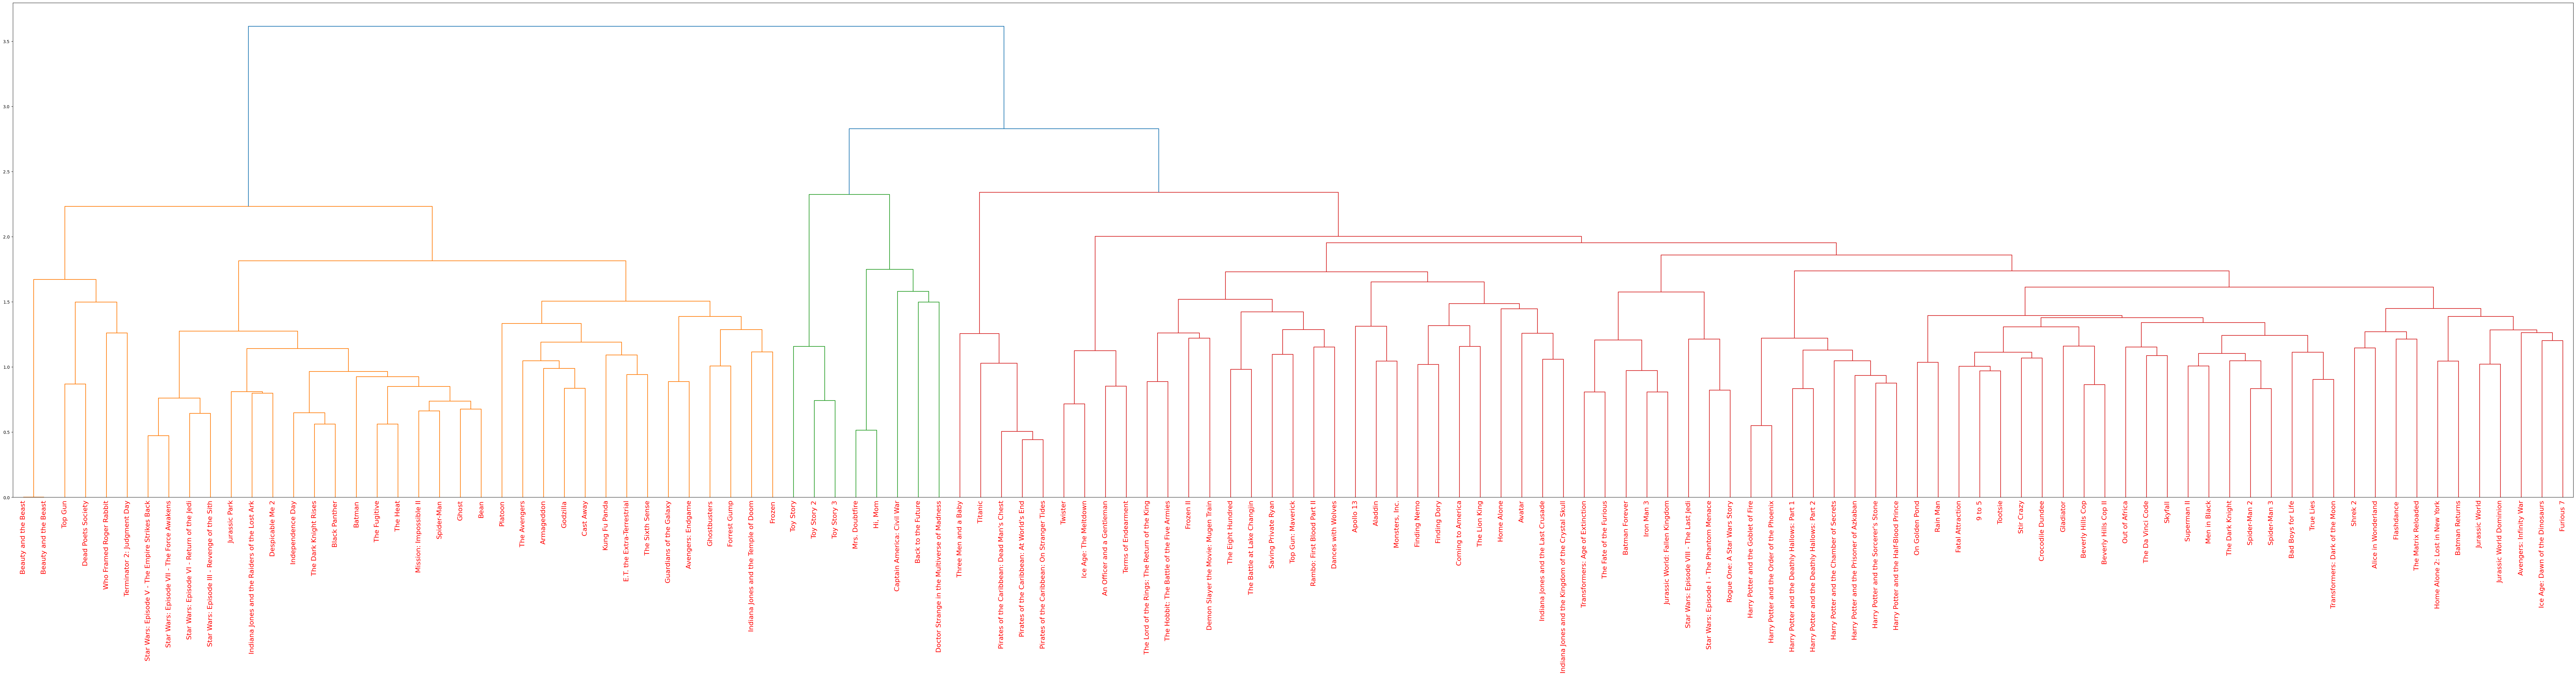

In [11]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram

mergings = linkage(similarity_distance, method='complete')
dendrogram_ = dendrogram(mergings, labels=[x for x in df["name"]], leaf_rotation=90,leaf_font_size=16)

fig = plt.gcf()
_ = [lbl.set_color('r') for lbl in plt.gca().get_xmajorticklabels()]
fig.set_size_inches(108, 21)

plt.show() # check the number of clusters forming (should be 5 to 6)

# **ML Model K-Means Clustering**

In [13]:
# categorize the data based on similarity of their plots
from sklearn.feature_extraction.text import TfidfVectorizer
def cluster_text(text):
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(text)
    import matplotlib.pyplot as plt
    from sklearn.cluster import KMeans
    Sum_of_squared_distances = []
    K = range(2,10)
    for k in K:
       km = KMeans(n_clusters=k, max_iter=200, n_init=10)
       km = km.fit(X)
       Sum_of_squared_distances.append(km.inertia_)
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

    print('How many clusters do you want to use?')
    true_k = int(input())
    model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
    model.fit(X)

    labels=model.labels_
    clusters=pd.DataFrame(list(zip(text,labels)),columns=['title','cluster'])

    return clusters

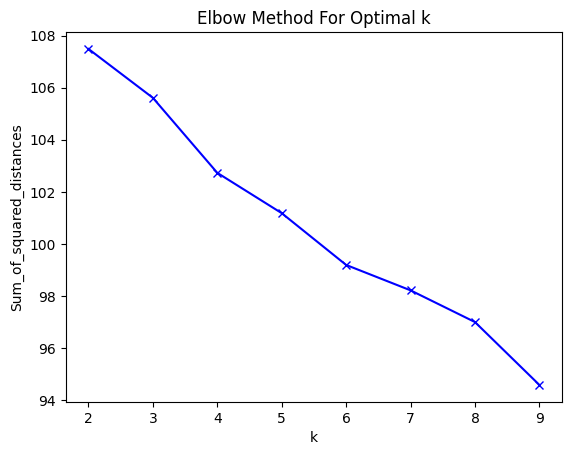

How many clusters do you want to use?
5


In [14]:
plots = cluster_text(df['script'])

In [15]:
plots.head()

,title,cluster
0,empire strikes back written lawrence kasdan le...,2
1,nine five script shes never worked life though...,1
2,needs hollywood hear theyre really nuts give t...,1
3,raiders lost ark screenplay lawrence kasdan st...,0
4,norman come come norman hurry loons loons they...,1


In [16]:
clusters = plots["cluster"].to_list()
df["cluster"] = clusters
df.head()

,name,year,running time,genre,script,cluster
0,Star Wars: Episode V - The Empire Strikes Back,1980,2 hr 4 min,Action Adventure Fantasy Sci-Fi,empire strikes back written lawrence kasdan le...,2
1,9 to 5,1980,1 hr 49 min,Comedy,nine five script shes never worked life though...,1
2,Stir Crazy,1980,1 hr 51 min,Comedy Crime,needs hollywood hear theyre really nuts give t...,1
3,Indiana Jones and the Raiders of the Lost Ark,1981,1 hr 55 min,Action Adventure,raiders lost ark screenplay lawrence kasdan st...,0
4,On Golden Pond,1981,1 hr 49 min,Drama,norman come come norman hurry loons loons they...,1


In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# Define sort_coo and extract_topn_from_vector functions (as provided earlier)
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

# Create a CountVectorizer instance and fit_transform your text data
cv = CountVectorizer()
word_count_vector = cv.fit_transform(df["script"])

# Use TfidfTransformer to calculate TF-IDF values from the CountVectorizer output
tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf_transformer.fit(word_count_vector)

def extract_keywords(doc, n):
    # Transform the document into TF-IDF vector using the TfidfVectorizer (cv)
    tf_idf_vector = tfidf_transformer.transform(cv.transform([doc]))

    # Get feature names from the TfidfVectorizer
    feature_names = cv.get_feature_names_out()

    # Sort the TF-IDF vectors by descending order of scores
    sorted_items = sort_coo(tf_idf_vector.tocoo())

    # Extract only the top n keywords
    keywords = extract_topn_from_vector(feature_names, sorted_items, n)

    # Print the results
    print("Keywords for the document:")
    for k, v in keywords.items():
        print(f"{k}: {v}")

    return



In [27]:
count = 1
for i in df["script"]:
    print("                         Movie:",count)
    extract_keywords(i,10)
    count = count + 1

                         Movie: 1
Keywords for the document:
luke: 0.463
han: 0.441
leia: 0.345
lando: 0.23
threepio: 0.225
chewie: 0.216
falcon: 0.198
vader: 0.193
artoo: 0.155
millennium: 0.127
                         Movie: 2
Keywords for the document:
hart: 0.54
violet: 0.405
judy: 0.263
canâ: 0.256
doralee: 0.183
dont: 0.131
get: 0.121
roz: 0.119
well: 0.106
gonna: 0.104
                         Movie: 3
Keywords for the document:
rodeo: 0.278
dont: 0.22
get: 0.21
bull: 0.205
donahue: 0.19
warden: 0.168
thats: 0.153
skip: 0.149
right: 0.14
harry: 0.123
                         Movie: 4
Keywords for the document:
indy: 0.827
marion: 0.325
belloq: 0.181
shliemann: 0.15
sallah: 0.129
ark: 0.107
indys: 0.101
satipo: 0.085
belzig: 0.079
nazis: 0.078
                         Movie: 5
Keywords for the document:
norman: 0.77
chelsea: 0.189
oh: 0.177
ethel: 0.162
billy: 0.131
chels: 0.109
thayer: 0.102
dont: 0.101
know: 0.098
well: 0.091
                         Movie: 6
Keywords for the 

# **Analyzing scripts classified plot wise**

In [28]:
# separating the 6 clusters into dataframes
plot0 = df[df["cluster"] == 0]
plot1 = df[df["cluster"] == 1]
plot2 = df[df["cluster"] == 2]
plot3 = df[df["cluster"] == 3]
plot4 = df[df["cluster"] == 4]

In [29]:
plot0 # rags to riches/Oedipus(fall-rise-fall)

,name,year,running time,genre,script,cluster
3,Indiana Jones and the Raiders of the Lost Ark,1981,1 hr 55 min,Action Adventure,raiders lost ark screenplay lawrence kasdan st...,0
6,E.T. the Extra-Terrestrial,1982,1 hr 55 min,Adventure Family Sci-Fi,et extraterrestrial melissa mathison commenta...,0
13,Ghostbusters,1984,1 hr 45 min,Action Comedy Fantasy Sci-Fi,real ghostbusters poultrygeist duane capizzi s...,0
14,Indiana Jones and the Temple of Doom,1984,1 hr 58 min,Action Adventure,indiana jones temple doom screenplay gloria ka...,0
18,Top Gun,1986,1 hr 50 min,Action Drama,top gun chip proser revised april registered...,0
20,Platoon,1986,2 hr,Drama War,platoon fade quotation black screen rejoice yo...,0
21,Three Men and a Baby,1987,1 hr 42 min,Comedy Drama Family,three men baby written coline serreau james or...,0
24,Who Framed Roger Rabbit,1988,1 hr 44 min,Adventure Animation Comedy Crime Family Fantas...,shot roger rabbit working title written jeffre...,0
27,Batman,1989,2 hr 6 min,Action Adventure,batman screenplay sam hamm based character cre...,0
29,Dead Poets Society,1989,2 hr 8 min,Comedy Drama,int welton academy hallway day young boy dress...,0


In [30]:
plot1 #voyage and return

,name,year,running time,genre,script,cluster
1,9 to 5,1980,1 hr 49 min,Comedy,nine five script shes never worked life though...,1
2,Stir Crazy,1980,1 hr 51 min,Comedy Crime,needs hollywood hear theyre really nuts give t...,1
4,On Golden Pond,1981,1 hr 49 min,Drama,norman come come norman hurry loons loons they...,1
5,Superman II,1981,2 hr 7 min,Action Adventure Sci-Fi,ill get door yeah thanks sorry yeah thanks lot...,1
7,Tootsie,1982,1 hr 56 min,Comedy Drama Romance,tootsie script thats right come dont stop keep...,1
8,An Officer and a Gentleman,1982,2 hr 4 min,Drama Romance,officer gentleman script passengers arriving p...,1
10,Terms of Endearment,1983,2 hr 12 min,Comedy Drama,terms endearment script let go minute youre go...,1
11,Flashdance,1983,1 hr 35 min,Drama Music Romance,flashdance script first theres nothing slow gl...,1
12,Beverly Hills Cop,1984,1 hr 45 min,Action Comedy Crime Thriller,truck looks great must fortune know front ok f...,1
15,Out of Africa,1985,2 hr 41 min,Biography Drama Romance,africa script even took gramophone safari thre...,1


In [31]:
plot2 # comedy(crime and drama):man in a hole(fall-rise)

,name,year,running time,genre,script,cluster
0,Star Wars: Episode V - The Empire Strikes Back,1980,2 hr 4 min,Action Adventure Fantasy Sci-Fi,empire strikes back written lawrence kasdan le...,2
9,Star Wars: Episode VI - Return of the Jedi,1983,2 hr 11 min,Action Adventure Fantasy Sci-Fi,return jedi lawrence kasdan george lucas novel...,2
38,Jurassic Park,1993,2 hr 7 min,Action Adventure Sci-Fi Thriller,jurassic park first draft michael crichton rew...,2
56,Star Wars: Episode I - The Phantom Menace,1999,2 hr 16 min,Action Adventure Fantasy Sci-Fi,fox fanfare theme music playing engines roarin...,2
73,Star Wars: Episode III - Revenge of the Sith,2005,2 hr 20 min,Action Adventure Fantasy Sci-Fi,star wars episode revenge sith script george ...,2
74,Pirates of the Caribbean: Dead Man's Chest,2006,2 hr 31 min,Action Adventure Fantasy,happening dont know look beautiful bad luck gr...,2
75,The Da Vinci Code,2006,2 hr 29 min,Mystery Thriller,stop tell brethren possess rightfully dont kno...,2
77,Pirates of the Caribbean: At World's End,2007,2 hr 49 min,Action Adventure Fantasy,order affect timely halt deteriorating conditi...,2
91,Pirates of the Caribbean: On Stranger Tides,2011,2 hr 17 min,Action Adventure Fantasy,majesty caught fishing net fishing net sire he...,2
101,Star Wars: Episode VII - The Force Awakens,2015,2 hr 18 min,Action Adventure Sci-Fi,star wars force awakens written lawrence kasda...,2


In [32]:
plot3 # overcoming the monster

,name,year,running time,genre,script,cluster
16,Back to the Future,1985,1 hr 56 min,Adventure Comedy Sci-Fi,back future writers robert zemeckis bob gale g...,3
33,Beauty and the Beast,1991,1 hr 24 min,Animation Family Fantasy Musical Romance,beauty beast written stephen chbosky evan spil...,3
39,Mrs. Doubtfire,1993,2 hr 5 min,Comedy Drama,enchantã© cher goã»ter tout bien rã©flã©chi fa...,3
82,Kung Fu Panda,2008,1 hr 32 min,Action Adventure Animation Comedy Family Fantasy,kung fu panda written jonathan aibel glenn ber...,3
95,Frozen,2013,1 hr 42 min,Adventure Animation Comedy Family Fantasy Musical,frozen written jennifer lee final shooting dra...,3
97,Despicable Me 2,2013,1 hr 38 min,Adventure Animation Comedy Crime Family Sci-Fi,despicable written cinco paul ken daurio ext ...,3
100,Guardians of the Galaxy,2014,2 hr 1 min,Action Adventure Comedy Sci-Fi,guardians galaxy vol written james gunn black...,3
108,Beauty and the Beast,2017,2 hr 9 min,Adventure Family Fantasy Musical Romance,beauty beast written stephen chbosky evan spil...,3


In [33]:
plot4 #the quest

,name,year,running time,genre,script,cluster
43,True Lies,1994,2 hr 21 min,Action Comedy Thriller,honey home roger copy boathouse right time fai...,4
53,Armageddon,1998,2 hr 31 min,Action Adventure Sci-Fi Thriller,armageddon fade blackness hint green becomes e...,4
62,Harry Potter and the Sorcerer's Stone,2001,2 hr 32 min,Adventure Family Fantasy,cat meows shouldve known would professor mcgon...,4
64,Harry Potter and the Chamber of Secrets,2002,2 hr 41 min,Adventure Family Fantasy Mystery,harry potter chamber secret cant let hedwig al...,4
70,Harry Potter and the Prisoner of Azkaban,2004,2 hr 22 min,Adventure Family Fantasy Mystery,boy lumos maxima lumos maxima tollet flushes h...,4
72,Harry Potter and the Goblet of Fire,2005,2 hr 37 min,Adventure Family Fantasy Mystery,dont know hot today isnt going get even worse ...,4
78,Harry Potter and the Order of the Phoenix,2007,2 hr 18 min,Action Adventure Family Fantasy Mystery,weatherman radio dont know hot today isnt goin...,4
84,Harry Potter and the Half-Blood Prince,2009,2 hr 33 min,Action Adventure Family Fantasy Mystery,killed sirius black hes back police continuing...,4
88,Harry Potter and the Deathly Hallows: Part 1,2010,2 hr 26 min,Adventure Family Fantasy Mystery,dark times denying world perhaps faced greater...,4
89,Harry Potter and the Deathly Hallows: Part 2,2011,2 hr 10 min,Adventure Fantasy Mystery,beautiful aunts used come kids order uses safe...,4


# **Movie Recommender**

In [12]:
import numpy as np
def find_similar(title):
    index = df[df["name"] == title].index[0]
    vector = similarity_distance[int(index),:]
    most_similar = df.iloc[np.argsort(vector)[1], 0]
    return most_similar

print(find_similar('Avengers: Endgame')) #Indiana Jones and the Kingdom of the Crystal Skull

Guardians of the Galaxy


# **Word Clouds**

In [34]:
from wordcloud import WordCloud

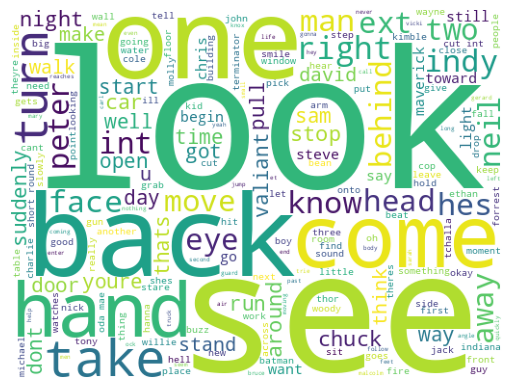

In [35]:
wordcloud = WordCloud (background_color = 'white',width = 512,height = 384).generate(' '.join(plot0['script']))
plt.imshow(wordcloud) # image show
plt.axis('off') # to off the axis of x and y
plt.show()

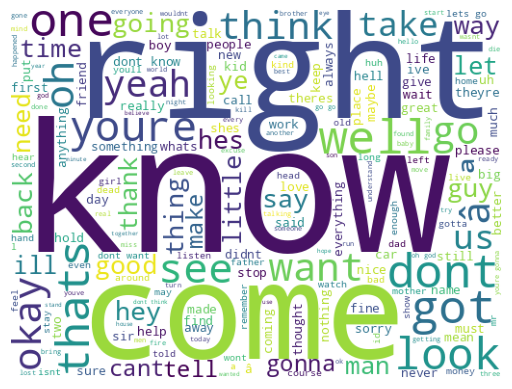

In [36]:
wordcloud = WordCloud (background_color = 'white',width = 512,height = 384).generate(' '.join(plot1['script']))
plt.imshow(wordcloud) # image show
plt.axis('off') # to off the axis of x and y
plt.show()

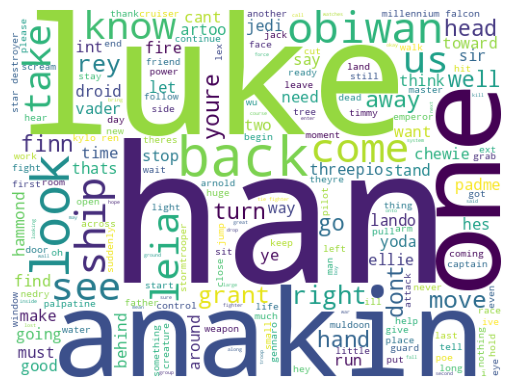

In [37]:
wordcloud = WordCloud (background_color = 'white',width = 512,height = 384).generate(' '.join(plot2['script']))
plt.imshow(wordcloud) # image show
plt.axis('off') # to off the axis of x and y
plt.show()

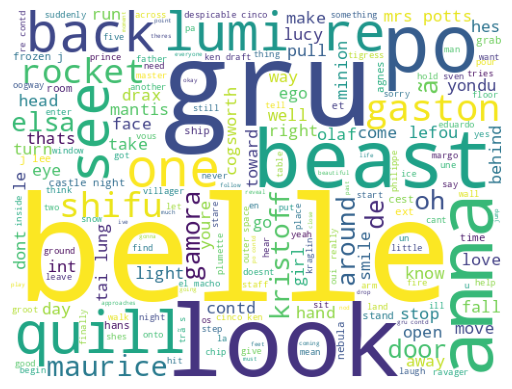

In [38]:
wordcloud = WordCloud (background_color = 'white',width = 512,height = 384).generate(' '.join(plot3['script']))
plt.imshow(wordcloud) # image show
plt.axis('off') # to off the axis of x and y
plt.show()

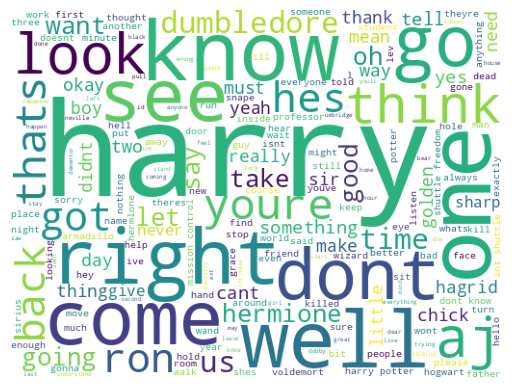

In [39]:
wordcloud = WordCloud (background_color = 'white',width = 512,height = 384).generate(' '.join(plot4['script']))
plt.imshow(wordcloud) # image show
plt.axis('off') # to off the axis of x and y
plt.show()

# **Exploratory Data Analysis**

In [40]:
eighties = df.query('year >= 1980 & year <= 1989')
ninties = df.query('year >= 1990 & year <= 1999')
hundreds = df.query('year >= 2000 & year <= 2009')
tens  = df.query('year >= 2010 & year <= 2019')
twenties = df.query('year >= 2020 & year <= 2022')

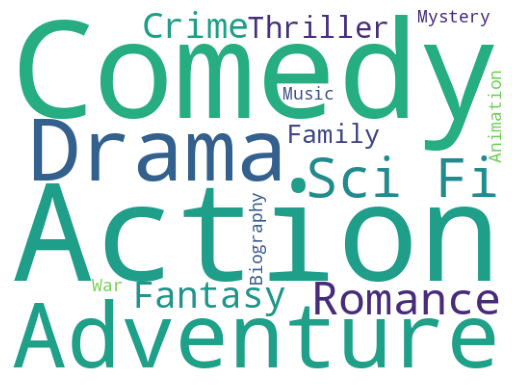

In [41]:
wordcloud = WordCloud (background_color = 'white',width = 512,height = 384).generate(' '.join(eighties['genre']))
plt.imshow(wordcloud) # image show
plt.axis('off') # to off the axis of x and y
plt.show()

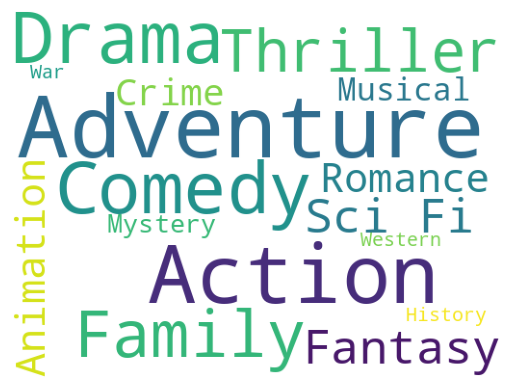

In [42]:
wordcloud2 = WordCloud (background_color = 'white',width = 512,height = 384).generate(' '.join(ninties['genre']))
plt.imshow(wordcloud2) # image show
plt.axis('off') # to off the axis of x and y
plt.show()

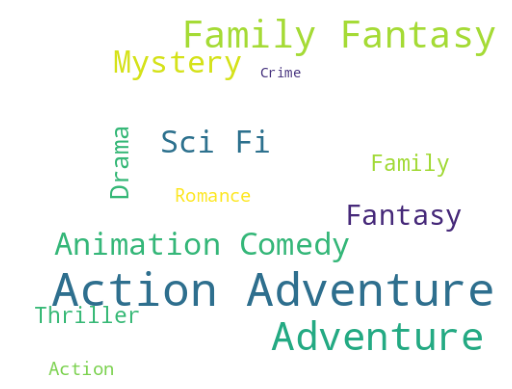

In [43]:
wordcloud3 = WordCloud (background_color = 'white',width = 512,height = 384).generate(' '.join(hundreds['genre']))
plt.imshow(wordcloud3) # image show
plt.axis('off') # to off the axis of x and y
plt.show()

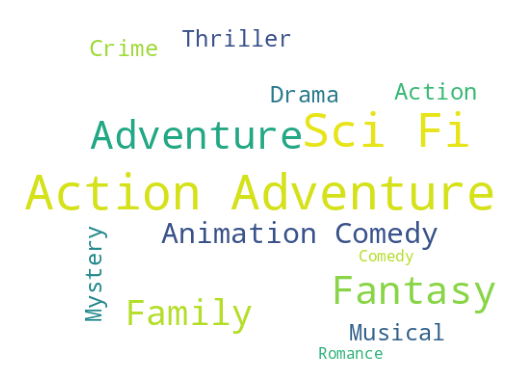

In [44]:
wordcloud4 = WordCloud (background_color = 'white',width = 512,height = 384).generate(' '.join(tens['genre']))
plt.imshow(wordcloud4) # image show
plt.axis('off') # to off the axis of x and y
plt.show()

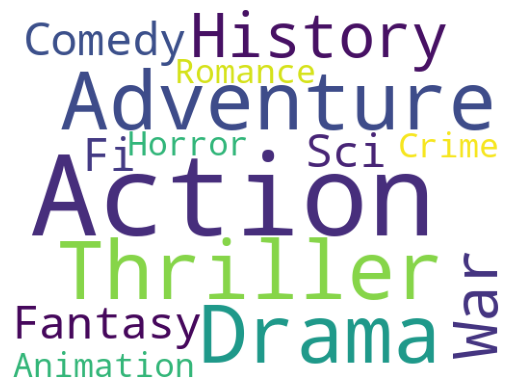

In [45]:
wordcloud5 = WordCloud (background_color = 'white',width = 512,height = 384).generate(' '.join(twenties['genre']))
plt.imshow(wordcloud5) # image show
plt.axis('off') # to off the axis of x and y
plt.show()

## **Silhouette_score (ML model)**

In [46]:
from sklearn.metrics import silhouette_score

# Assuming 'tfidf_matrix' contains the TF-IDF matrix from your code
# 'true_labels' represents the true labels (if available)

# Using KMeans to cluster
from sklearn.cluster import KMeans

# Example with K=5 clusters (you can use the optimal number of clusters found using the elbow method)
k = 5
kmeans = KMeans(n_clusters=k, max_iter=200, n_init=10)
kmeans.fit(tfidf_matrix)

# Get predicted labels
predicted_labels = kmeans.labels_

# Calculate silhouette score
silhouette_avg = silhouette_score(tfidf_matrix, predicted_labels)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.07598088105157319


# **Deep Learning (BERT)**

In [49]:
import json
import pandas as pd
from transformers import BertModel, BertTokenizer
from sklearn.decomposition import PCA  # Add this import statement for PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

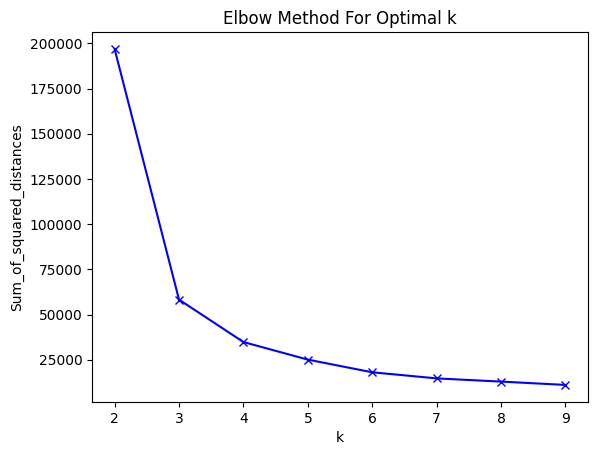

In [54]:
# Prepare BERT tokenizer and model
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# Tokenize and generate BERT embeddings for text data
text_data = df['script']
encoded_input = tokenizer(text_data.tolist(), padding=True, truncation=True, return_tensors='pt')
with torch.no_grad():
    outputs = model(**encoded_input)
    embeddings = outputs.last_hidden_state  # Extract BERT embeddings

reshaped_embeddings = np.reshape(embeddings, (embeddings.shape[0], -1))

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)  # Assuming 2 components for visualization
embeddings_reduced = pca.fit_transform(reshaped_embeddings)

# Determine the optimal number of clusters using the elbow method
Sum_of_squared_distances = []
K = range(2, 10)
for k in K:
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(embeddings_reduced)
    Sum_of_squared_distances.append(km.inertia_)

# Plot the elbow method curve
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

# Choose the optimal k (number of clusters)
k = 5  # Example: set the number of clusters based on the elbow method

# Apply KMeans clustering
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=200, n_init=10)
clusters = kmeans.fit_predict(embeddings_reduced)


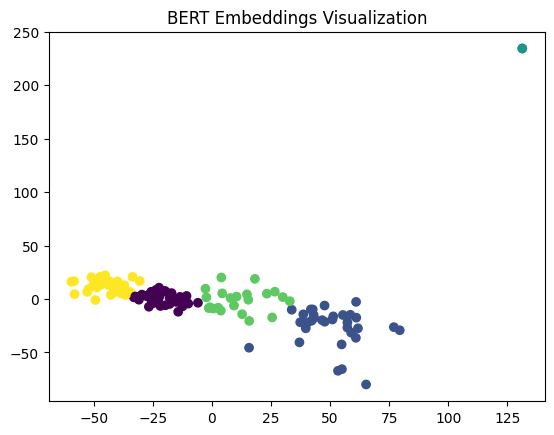

In [55]:
# Visualize clusters
plt.scatter(embeddings_reduced[:, 0], embeddings_reduced[:, 1], c=clusters, cmap='viridis')
plt.title('BERT Embeddings Visualization')
plt.show()

## **Silhouette score**

In [56]:

# Calculate Silhouette Score
silhouette_avg = silhouette_score(embeddings_reduced, clusters)
print(f"Silhouette Score: {silhouette_avg}")


Silhouette Score: 0.4903025873902384
